# 分析IRAs

In [1]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [8]:
user_data = pd.read_csv('data/ira_users_csv_hashed.csv')
user_data.head()

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
0,94c383089f0dd9993020276bd01113ecb5935ad860bfa6...,94c383089f0dd9993020276bd01113ecb5935ad860bfa6...,94c383089f0dd9993020276bd01113ecb5935ad860bfa6...,USA,Conservative. Politics. Pro-Life. Writer. #Go...,NaN,1541,1676,2014-06-13,en
1,799bb58d3c064d3884fdc4604c74068ff059b60c0b3464...,799bb58d3c064d3884fdc4604c74068ff059b60c0b3464...,799bb58d3c064d3884fdc4604c74068ff059b60c0b3464...,Раша,На воре и шапка горит,NaN,299,324,2013-12-22,en
2,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea958...,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea958...,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea958...,"Чеченская республика, Россия",Я никогда не хотел стать президентом. У меня в...,NaN,4094,0,2016-11-25,ru
3,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868...,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868...,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868...,US,❥ ❣ my sweethearts)),NaN,140,191,2013-08-11,en
4,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8...,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8...,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8...,NaN,NaN,NaN,119,1152,2016-07-06,de


In [9]:
user_data.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

In [10]:
user_data.describe()

,follower_count,following_count
count,3836.000000,3836.000000
mean,1664.950209,826.092023
std,8860.043408,2726.252326
min,0.000000,0.000000
25%,58.000000,104.000000
50%,126.000000,239.000000
75%,461.250000,542.000000
max,257638.000000,74664.000000


In [11]:
# %matplotlib inline

def get_cdf_pdf(data, mini, maxi, step, norm=True):
    x = [float(i) for i in np.arange(mini, maxi, step)]
    cdf = [0] * len(x)
    pdf = [0] * len(x)
    count = 0
    for d in data:
        d = float(d)
        if d < mini or d > maxi:
            continue
        count += 1
        for i in range(len(x)):
            if i == (len(x) - 1) and d >= x[i]:
                pdf[i] += 1
            elif d >= x[i] and d < x[i+1]:
                pdf[i] += 1

            if d >= x[i]:
                cdf[i] += 1

    if norm:
        cdf = [c / count for c in cdf]
        pdf = [p / count for p in pdf]

    return x, cdf, pdf

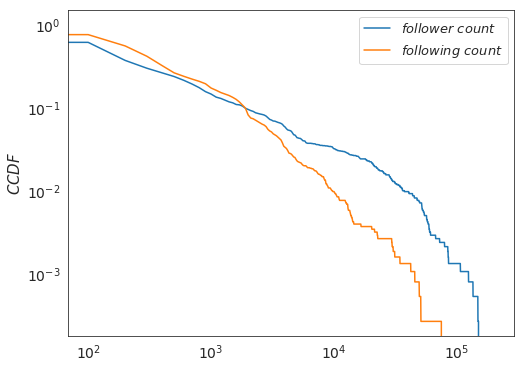

In [26]:
# user_data
plt.figure(figsize=(8, 6))
x, cdf, pdf = get_cdf_pdf(user_data['follower_count'], 0, 200000, 100)
plt.xscale('log'); plt.yscale('log')
plt.plot(x, cdf, label='$follower\ count$')

pd.DataFrame({'x': x, 'cdf': cdf}).to_csv('dist_follower_count.csv')


x, cdf, pdf = get_cdf_pdf(user_data['following_count'], 0, 100000, 100)
plt.ylabel('$CCDF$', fontsize=15)
pd.DataFrame({'x': x, 'cdf': cdf}).to_csv('dist_following_count.csv')


plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xscale('log'); plt.yscale('log')

plt.plot(x, cdf, label='$following\ count$')
plt.legend(fontsize=13)
plt.savefig('fig/fol.pdf', dpi=300)
plt.show()



In [23]:
user_data.iloc[user_data['follower_count'].idxmax(), :]

userid                                                             2527472164
user_display_name                                              Вестник Москвы
user_screen_name                                                   NovostiMsk
user_reported_location                                                 Москва
user_profile_description    Невозможно не любить этот город! Телефон редак...
user_profile_url                                      https://t.co/sIJZDK1hTI
follower_count                                                         257638
following_count                                                           544
account_creation_date                                     2014-05-04 00:00:00
account_language                                                           en
Name: 1014, dtype: object

In [24]:
user_data.iloc[user_data['following_count'].idxmax(), :]

userid                                                             4224729994
user_display_name                                                   Tennessee
user_screen_name                                                      TEN_GOP
user_reported_location                                                    NaN
user_profile_description    Unofficial Twitter of Tennessee Republicans. C...
user_profile_url                                                          NaN
follower_count                                                         147767
following_count                                                         74664
account_creation_date                                     2015-11-19 00:00:00
account_language                                                           en
Name: 2642, dtype: object

In [15]:
# user_data.groupby('account_creation_date').count()
user_data['account_creation_date'] = pd.to_datetime(user_data['account_creation_date'])
A = user_data.set_index('account_creation_date')
B = A.to_period('M').groupby('account_creation_date').count()
# creation_dates = pd.to_datetime(user_data["account_creation_date"])
# pd.date_range(2010)
# sum(B['userid'])

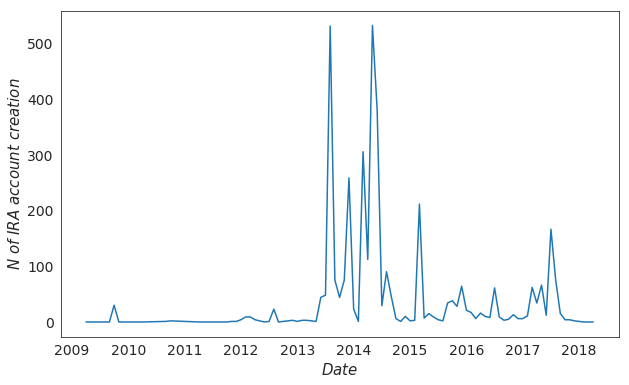

In [16]:
plt.figure(figsize=(10, 6))
# plt.plot_date(B.index, B['userid'])
B['userid'].plot()
plt.xlabel('$Date$', fontsize=15); plt.ylabel('$N\ of\ IRA\ account\ creation$', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig('fig/account_creation.pdf', dpi=300)
plt.show()

B.to_csv('account_creation.csv')

In [28]:
# load tweets

tweets = pd.read_csv('data/ira_tweets_csv_hashed.csv', low_memory=False)
tweets.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
0,877919995476496385,249064136b1c5cb00a705316ab73dd9b53785748ab757f...,249064136b1c5cb00a705316ab73dd9b53785748ab757f...,249064136b1c5cb00a705316ab73dd9b53785748ab757f...,"Москва, Россия",Я примерный семьянин!,NaN,132,120,2013-12-07,...,NaN,NaN,0.0,0.0,0.0,0.0,[],[http://ru-open.livejournal.com/374284.html],[2572896396],NaN
1,492388766930444288,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624...,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624...,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624...,Россия,Телефонист .Изучение истории Игра в любитель...,NaN,74,8,2014-03-15,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,[http://pyypilg33.livejournal.com/11069.html],NaN,NaN
2,719455077589721089,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,Рязань,волны так и плещут фиолетовой волной,NaN,165,454,2014-04-29,...,NaN,NaN,0.0,0.0,0.0,0.0,[],[https://www.youtube.com/watch?v=9GvpImWxTJc],[40807205],NaN
3,536179342423105537,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,bda40f262856eee77c48a332e5eb23bc4f1943d600867d...,Рязань,волны так и плещут фиолетовой волной,NaN,165,454,2014-04-29,...,NaN,NaN,0.0,0.0,0.0,0.0,[STOPNazi],NaN,NaN,NaN
4,841410788409630720,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf34...,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf34...,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf34...,NaN,Отвечаю на любой #ВопросПрезиденту,http://t.co/3CVqbMQFbf,4430,4413,2012-02-25,...,NaN,NaN,0.0,0.0,3.0,4.0,[],[https://goo.gl/fBp94X],NaN,NaN


In [144]:
tweets.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [3]:
tweets.describe()

,tweetid,follower_count,following_count,in_reply_to_tweetid,quoted_tweet_tweetid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count
count,9.041308e+06,9.041308e+06,9.041308e+06,2.662080e+05,1.879130e+05,3.333184e+06,4779.000000,4779.000000,9.038635e+06,9.038635e+06,9.038635e+06,9.038635e+06
mean,6.403835e+17,8.670202e+03,2.522468e+03,6.111953e+17,7.965433e+17,6.711430e+17,53.958520,61.841277,1.981891e-01,2.810441e-01,4.002723e+00,3.457440e+00
std,1.550236e+17,2.214639e+04,5.028831e+03,1.334171e+17,8.698341e+16,1.232434e+17,12.332756,22.985006,1.307364e+01,7.408997e+00,2.903125e+02,1.403270e+02
min,1.747086e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.834783e+09,1.000000e+02,-43.323251,-115.148349,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.267902e+17,3.460000e+02,2.840000e+02,5.730938e+17,7.742985e+17,5.710871e+17,55.038939,37.660071,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.221623e+17,8.420000e+02,6.180000e+02,6.325940e+17,8.102428e+17,6.531061e+17,55.039231,73.275546,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.800047e+17,4.486000e+03,2.014000e+03,6.568322e+17,8.500103e+17,7.946743e+17,56.367504,73.279744,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.009806e+18,2.576380e+05,7.466400e+04,1.001021e+18,9.989833e+17,1.001554e+18,61.879338,171.602940,1.163300e+04,3.249000e+03,3.258260e+05,1.236170e+05


In [15]:
# user_data['account_creation_date'] = pd.to_datetime(user_data['account_creation_date'])
tweets['tweet_time'] = pd.to_datetime(tweets['tweet_time'])

A = tweets.set_index('tweet_time')
B = A.to_period('M').groupby('tweet_time').count()

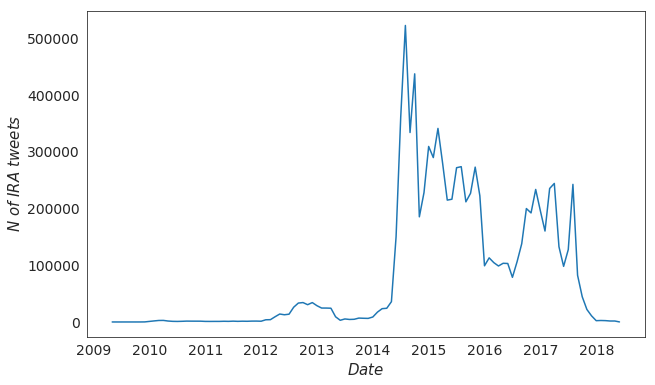

In [19]:
plt.figure(figsize=(10, 6))
# plt.plot_date(B.index, B['userid'])
B['tweetid'].plot()
plt.xlabel('$Date$', fontsize=15); plt.ylabel('$N\ of\ IRA\ tweets$', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig('fig/tweet_creation.pdf', dpi=300)
plt.show()

B['tweetid'].to_csv('tweet_creation.csv')

In [38]:
from urllib.parse import urlparse
import requests

for i, row in tweets.iterrows():
    if not isinstance(row['urls'], str):
        tweets.drop(i)
    elif row['urls'][1: -1] == '':
        tweets.drop(i)
    else:
        url = row['urls'][1: -1]
        res = requests.head(url)
        hostname = urlparse(res.headers.get('location')).hostname
        if hostname:
            print(i, url, '>', hostname)
        else:
            tweets.drop(i)
        
#     print(row)
#     if isinstance(urls, str):
#         url = urls[1: -1]
#         if url:
# #             hostname = urllib.parse.urlparse(url).hostname
#             res = requests.head(url)
#             hostname = urlparse(res.headers.get('location')).hostname
#             if hostname:
#                 print(hostname, type(hostname))



0 http://ru-open.livejournal.com/374284.html > ru-open.livejournal.com
1 http://pyypilg33.livejournal.com/11069.html > pyypilg33.livejournal.com
4 https://goo.gl/fBp94X > www.putin-today.ru
5 https://goo.gl/9w5hso > www.putin-today.ru
7 http://bit.ly/1Rizso9 > sibkray.ru
9 http://vesti.ru/t?2686779 > www.vesti.ru
13 http://bit.ly/1PMZqPI > progorod43.ru
14 http://bit.ly/1qYzyIL > progorod43.ru
15 http://bit.ly/1TK58o0 > progorod43.ru
16 http://bit.ly/22rNBnQ > progorod43.ru
17 http://bit.ly/1h8fA98 > progorod43.ru
18 http://bit.ly/1pjYCsY > progorod43.ru
19 https://goo.gl/cxchK2 > www.gtrk-vyatka.ru
20 https://goo.gl/3W1BDT > www.gtrk-vyatka.ru
21 http://bit.ly/1ZW60eL > progorod43.ru
22 http://dlvr.it/Nb8xqd > gorodkirov.ru
23 http://dlvr.it/NxBKlR > www.gtrk-vyatka.ru
24 http://dlvr.it/PjZQ1z > www.gtrk-vyatka.ru
25 https://goo.gl/MplXgE > www.gtrk-vyatka.ru
26 https://goo.gl/vC26US > www.gtrk-vyatka.ru
27 http://dlvr.it/Pb4w8b > www.gtrk-vyatka.ru
28 http://dlvr.it/Ppg179 > gorodkir

In [47]:
# build retweet networks

userid_map = json.load(open("data/userid_mapping.json"))
G = nx.DiGraph()
G.add_nodes_from(userid_map.values())
# G.number_of_nodes()

for i, row in tweets.iterrows():
    if row["is_retweet"]:
        if row['retweet_userid'] in userid_map:
            ret_userid = userid_map[row['retweet_userid']]
            userid = userid_map[row['userid']]
            if ret_userid != userid:
                G.add_edge(ret_userid, userid)

# save the network
nx.readwrite.adjlist.write_adjlist(G, 'retweet_net_in_IRA.dat')

In [21]:
G = nx.readwrite.adjlist.read_adjlist('retweet_net_in_IRA.dat')

In [48]:
G.number_of_nodes()

3836

In [49]:
G.number_of_edges()

168074

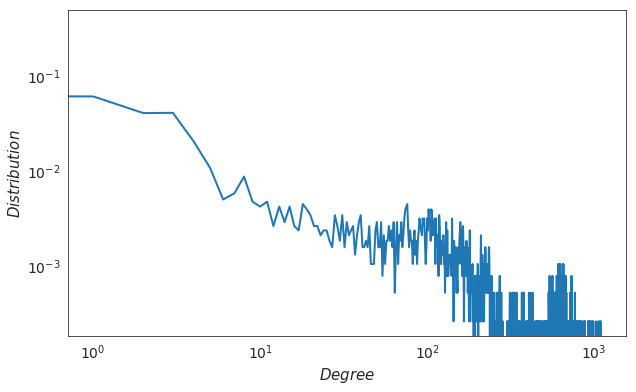

0 76
1 236
14 633
21 656
22 676
104 682
372 700
836 702
857 838
986 944
1020 1027
2168 1084
2274 1088
3585 1092


KeyError: 3585

In [66]:
plt.figure(figsize=(10, 6))

degree = nx.degree_histogram(G)
x = range(len(degree))                             
y = [z / float(sum(degree)) for z in degree]  
plt.loglog(x, y, linewidth=2)
plt.xlabel('$Degree$', fontsize=15); plt.ylabel('$Distribution$', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig('fig/degree_distribution.pdf', dpi=300)
plt.show()

d = dict(G.degree())
n, de = 0, 0
for k, v in d.items():
    if v > de:
        print(k, v)
        n, de = k, v
        
userid_map = json.load(open("data/userid_mapping.json"))
userid_map[n]

33162


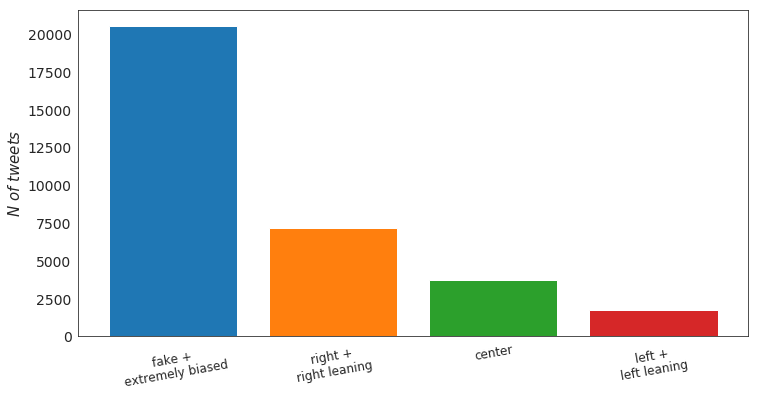

In [59]:
plt.figure(figsize=(12, 6))
x = [11638 + 8910, 42 + 7102, 3707, 1042 + 721]
print(sum(x))
label = ['fake +\n extremely biased', 'right +\nright leaning', 'center', 'left +\nleft leaning']
plt.bar(1, x[0])
plt.bar(2, x[1])
plt.bar(3, x[2])
plt.bar(4, x[3])
plt.xticks([1, 2, 3, 4], label, rotation=10)
plt.ylabel('$N\ of\ tweets$', fontsize=15)
plt.xticks(fontsize=12); plt.yticks(fontsize=14)
plt.savefig('fig/fake_news_bar.pdf', dpi=300)
plt.show()
